# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
 -1
  1
 -1
  1
  1
  1
  1
  ⋮
 -1
 -1
  1
  1
 -1
  1
  1
  1
  1

### We create a function to visualize the data

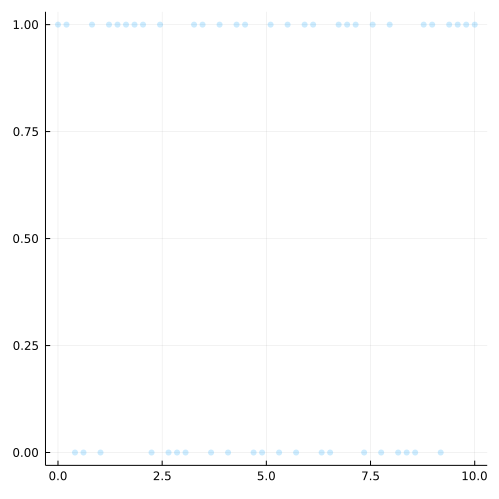

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.205661 seconds (1.82 M allocations: 103.871 MiB, 99.54% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.7659581987492255, 0.7334423420362476, 0.7186207805806136, 0.7249847558849646, 0.7500549648284486, 0.7847052962984061, 0.8160247388721409, 0.830640462018688, 0.8199034885168321, 0.7830263733004748  …  0.6094977658168915, 0.6036278337728589, 0.600722846350326, 0.6219352985116496, 0.6840075004992714, 0.7830732093320801, 0.8982413326957338, 1.0055716724721242, 1.0878671075770947, 1.1369612990291997], θ = [0.23845416556110086, 0.23936471316249114, 0.2397693414005719, 0.23959641493863676, 0.23890339244587996, 0.23791521072685085, 0.23699263311927316, 0.23655280967098707, 0.2368764808724023, 0.23796388756640843  …  0.24253776708270264, 0.24267578458962494, 0.24274366381708598, 0.24224155520002644, 0.24068821197399656, 0.23796253074154644, 0.23444474692192588, 0.2308663131581899, 0.2279505185

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:07:19
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:43
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:28
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:51
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:28
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:13
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:01:03
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:55
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:36
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[1.0621677008949515, 0.8711016572796926, 0.6728951400332022, 0.5820261780237265, 0.5714031019185044, 0.5630459538506093, 0.5974166536611926, 0.6501325719505244, 0.6394066502433853, 0.6079404652202749  …  -0.3829817996383373, -0.3777223855872034, -0.33237513995671897, -0.17581614602630233, -0.0041531963505597735, 0.21594507000986596, 0.4352091803581559, 0.6367640389198295, 0.7597515072541157, 0.8247612781246498]]
 [[0.24562634007842618, 0.2250190582515221, 0.33534446001009766, 0.46705929031284993, 0.645897754482174, 0.8264521408616787, 0.9077707226634119, 0.9495581905268735, 0.9623317004028624, 0.9925101529435003  …  0.08377149821735216, -0.15396503668335842, -0.43394342562081695, -0.7118349656859296, -0.9143610540120977, -0.9811628813726181, -0.9032462830430901, -0.6823092279136599, -0.38875486836891815, -0.025481438103668097]]
 [[-0.10937088248436028, 0.04349849148762436, 0.14861803453419345, 0.23314967931343916, 0.28329892212113833, 0.4

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

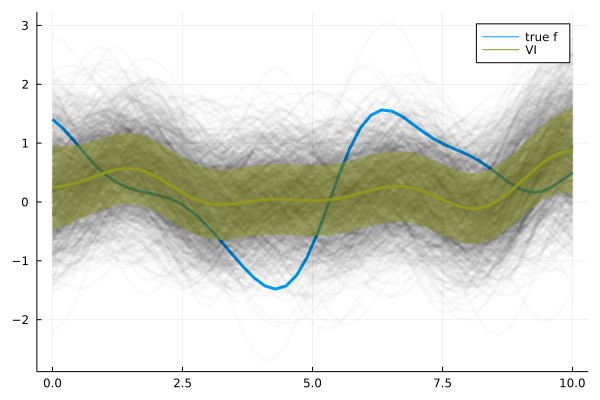

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

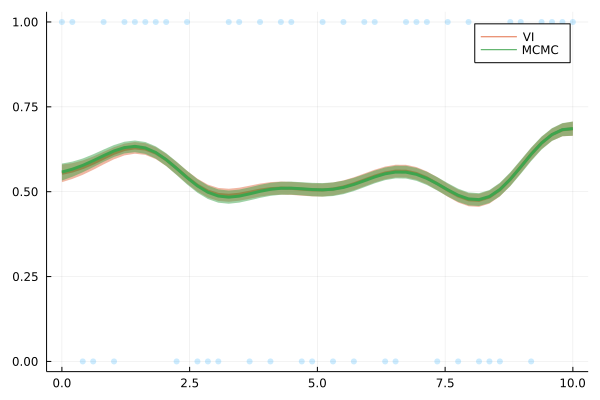

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*